In [1]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
#Генерация линейно разделенных данных
mean1 = np.array([0, 2])
mean2 = np.array([2, 0])
cov = np.array([[0.8, 0.6], [0.6, 0.8]])
X1 = np.random.multivariate_normal(mean1, cov, 100)
y1 = np.ones(len(X1))
X2 = np.random.multivariate_normal(mean2, cov, 100)
y2 = np.ones(len(X2)) * -1

In [3]:
# Разделение на обучающую и тестовую последовательность
X1_train = X1[:90]
y1_train = y1[:90]
X2_train = X2[:90]
y2_train = y2[:90]
X_train = np.vstack((X1_train, X2_train))
y_train = np.hstack((y1_train, y2_train))

X1_test = X1[90:]
y1_test = y1[90:]
X2_test = X2[90:]
y2_test = y2[90:]
X_test = np.vstack((X1_test, X2_test))
y_test = np.hstack((y1_test, y2_test))

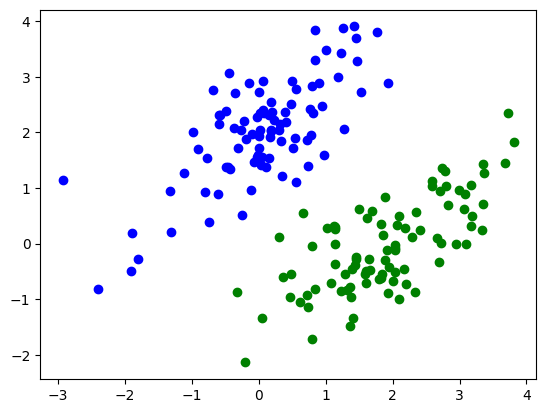

In [4]:
plt.plot(X1_train[:,0], X1_train[:,1],"bo")
plt.plot(X2_train[:,0], X2_train[:,1], "go")
plt.axis("tight")
plt.show()

Создание SVM классификатора

In [5]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [6]:
kernel = linear_kernel
# Разделение на кол-во наблюдений и на кол-во признаков
n_samples, n_features = X_train.shape

#Создание матрицы из скалярного произв векторов
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
  for j in range(n_samples):
    K[i,j] = kernel(X_train[i], X_train[j])

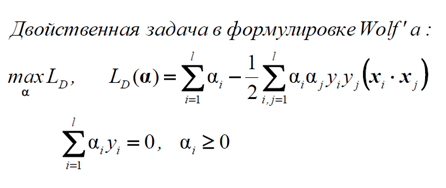

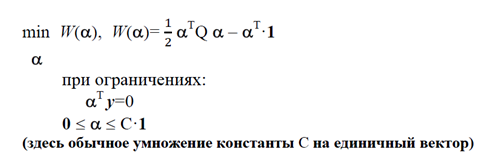

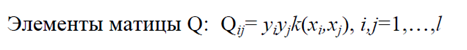

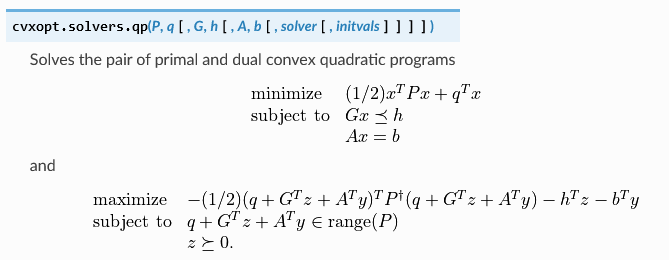

In [7]:
# Ставим задачу квадратичного программирования

P = cvxopt.matrix(np.outer(y_train,y_train) * K)
q = cvxopt.matrix(np.ones(n_samples) * -1)
A = cvxopt.matrix(y_train, (1,n_samples))
b = cvxopt.matrix(0.0)

G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
h = cvxopt.matrix(np.zeros(n_samples))

# Решаем задачу квадратичного программирования
solution = cvxopt.solvers.qp(P, q, G, h, A, b)
solution

     pcost       dcost       gap    pres   dres
 0: -1.9365e+01 -3.7944e+01  6e+02  2e+01  2e+00
 1: -2.9253e+01 -2.5150e+01  3e+02  1e+01  8e-01
 2: -4.6288e+01 -3.5691e+01  3e+02  9e+00  7e-01
 3: -9.3781e+01 -3.7377e+01  1e+02  4e+00  3e-01
 4: -1.2281e+01 -8.5581e+00  4e+01  8e-01  6e-02
 5: -8.6161e+00 -9.6540e+00  4e+01  6e-01  5e-02
 6: -6.2769e+00 -8.0464e+00  1e+01  1e-01  1e-02
 7: -7.1284e+00 -7.4400e+00  7e-01  6e-03  5e-04
 8: -7.4217e+00 -7.4249e+00  7e-03  6e-05  5e-06
 9: -7.4247e+00 -7.4248e+00  7e-05  6e-07  5e-08
10: -7.4248e+00 -7.4248e+00  7e-07  6e-09  5e-10
Optimal solution found.


{'x': <180x1 matrix, tc='d'>,
 'y': <1x1 matrix, tc='d'>,
 's': <180x1 matrix, tc='d'>,
 'z': <180x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 6.796507781209243e-07,
 'relative gap': 9.153831133941693e-08,
 'primal objective': -7.424768582422634,
 'dual objective': -7.424768902314209,
 'primal infeasibility': 6.240449876227205e-09,
 'dual infeasibility': 4.97024047893073e-10,
 'primal slack': 5.54461275879387e-10,
 'dual slack': 8.091393606132686e-10,
 'iterations': 10}

In [8]:
# Коэф Лагранжа
a = np.ravel(solution['x'])

In [9]:
# Опорные векторы имеют ненулевые множители Ларанжа
sv = a > 1e-3
ind = np.arange(len(a))[sv]
a = a [sv]

sv_x = X_train[ind]
sv_y = y_train[ind]

print("%d support vectors out of %d points" % (len(a), n_samples))

3 support vectors out of 180 points


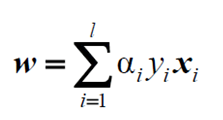

In [10]:
# Весовой вектор w
w = np.zeros(n_features)
for n in range(len(a)):
  w += a[n] * sv_y[n] * sv_x[n]
w

array([-2.29413531,  3.09620414])

In [11]:
margin = 2/norm(w)
margin = round(margin,2)

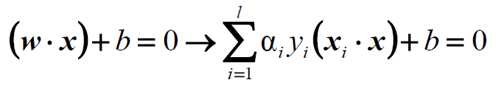

In [12]:
# Коэф b
b = 0
for n in range(len(a)):
  b += sv_y[n]
  b -= np.sum(a * sv_y * K[ind[n],sv])
b /= len(a)
b

-1.1634071584818455

In [13]:
#Классификация тестовой выборки
f = np.dot(X_test, w) + b
y_predict = np.sign(f)

Точность классификации

In [14]:
print('Точность классификации:', accuracy_score(y_test, y_predict))
correct = np.sum(y_predict == y_test)
print("%d out of %d predictions correct" % (correct, len(y_predict)))

Точность классификации: 1.0
20 out of 20 predictions correct


Построение графика

In [15]:
def f(x, w, b, c=0):
  # w.x + b = c
  return (-w[0] * x - b + c) / w[1]

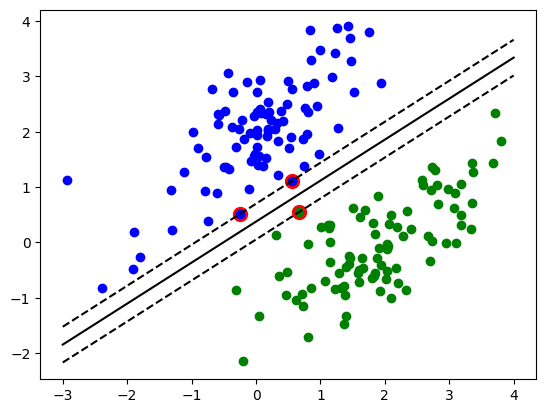

In [16]:
plt.plot(X1_train[:,0], X1_train[:,1],"bo")
plt.plot(X2_train[:,0], X2_train[:,1], "go")
#Опорные векторы обведены красным
plt.scatter(sv_x[:,0], sv_x[:,1], s=100, c="r")

# w.x + b = 0
a0 = -3; a1 = f(a0, w, b)
b0 = 4; b1 = f(b0, w, b)
plt.plot([a0,b0], [a1,b1], "k")

# w.x + b = 1
a0 = -3; a1 = f(a0, w, b, 1)
b0 = 4; b1 = f(b0, w, b, 1)
plt.plot([a0,b0], [a1,b1], "k--")

# w.x + b = -1
a0 = -3; a1 = f(a0, w, b, -1)
b0 = 4; b1 = f(b0, w, b, -1)
plt.plot([a0,b0], [a1,b1], "k--")



plt.axis("tight")
plt.show()